In [88]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [89]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [90]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [91]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [92]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
            
        ) # output_size = 24
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2)
         # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 11
        
        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(dropout_value)
           
        ) # output_size = 9
        #self.pool2 = nn.MaxPool2d(2, 2)
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 7

        

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(16),
            #nn.ReLU(),
            #nn.Dropout(dropout_value)
       #) # output_size = 7

        #self.convblock8 = nn.Sequential(
            #nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        #x = self.pool1(x)
        #x = self.dropout(x)
        
        x = self.convblock4(x)
       
        x = self.convblock5(x)
        #x = self.pool2(x)
        x = self.convblock6(x)
        
        #x = self.dropout(x)
        x = self.gap(x) 
        x = self.convblock7(x)
        #x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [93]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           2,304
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14             [

In [95]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [96]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.1162916049361229 Batch_id=468 Accuracy=91.29: 100%|███████████████████████████| 469/469 [00:07<00:00, 80.91it/s]



Test set: Average loss: 0.0481, Accuracy: 9862/10000 (98.62%)

EPOCH: 1


Loss=0.05616094172000885 Batch_id=468 Accuracy=97.64: 100%|██████████████████████████| 469/469 [00:07<00:00, 61.17it/s]



Test set: Average loss: 0.0513, Accuracy: 9836/10000 (98.36%)

EPOCH: 2


Loss=0.11810651421546936 Batch_id=468 Accuracy=98.03: 100%|██████████████████████████| 469/469 [00:12<00:00, 80.33it/s]



Test set: Average loss: 0.0314, Accuracy: 9899/10000 (98.99%)

EPOCH: 3


Loss=0.021130084991455078 Batch_id=468 Accuracy=98.24: 100%|█████████████████████████| 469/469 [00:07<00:00, 80.65it/s]



Test set: Average loss: 0.0363, Accuracy: 9887/10000 (98.87%)

EPOCH: 4


Loss=0.10834845155477524 Batch_id=468 Accuracy=98.39: 100%|██████████████████████████| 469/469 [00:07<00:00, 62.83it/s]



Test set: Average loss: 0.0300, Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Loss=0.03899098560214043 Batch_id=468 Accuracy=98.48: 100%|██████████████████████████| 469/469 [00:07<00:00, 62.47it/s]



Test set: Average loss: 0.0252, Accuracy: 9920/10000 (99.20%)

EPOCH: 6


Loss=0.022102728486061096 Batch_id=468 Accuracy=98.58: 100%|█████████████████████████| 469/469 [00:07<00:00, 60.85it/s]



Test set: Average loss: 0.0258, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Loss=0.0121208680793643 Batch_id=468 Accuracy=98.63: 100%|███████████████████████████| 469/469 [00:07<00:00, 61.30it/s]



Test set: Average loss: 0.0216, Accuracy: 9935/10000 (99.35%)

EPOCH: 8


Loss=0.030048644170165062 Batch_id=468 Accuracy=98.77: 100%|█████████████████████████| 469/469 [00:12<00:00, 37.28it/s]



Test set: Average loss: 0.0210, Accuracy: 9930/10000 (99.30%)

EPOCH: 9


Loss=0.002635945798829198 Batch_id=468 Accuracy=98.78: 100%|█████████████████████████| 469/469 [00:07<00:00, 60.36it/s]



Test set: Average loss: 0.0225, Accuracy: 9924/10000 (99.24%)

EPOCH: 10


Loss=0.03299098461866379 Batch_id=468 Accuracy=98.72: 100%|██████████████████████████| 469/469 [00:12<00:00, 37.86it/s]



Test set: Average loss: 0.0260, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.03195049613714218 Batch_id=468 Accuracy=98.73: 100%|██████████████████████████| 469/469 [00:07<00:00, 61.06it/s]



Test set: Average loss: 0.0217, Accuracy: 9926/10000 (99.26%)

EPOCH: 12


Loss=0.04026757553219795 Batch_id=468 Accuracy=98.86: 100%|██████████████████████████| 469/469 [00:07<00:00, 59.72it/s]



Test set: Average loss: 0.0181, Accuracy: 9944/10000 (99.44%)

EPOCH: 13


Loss=0.0159068014472723 Batch_id=468 Accuracy=98.83: 100%|███████████████████████████| 469/469 [00:07<00:00, 60.81it/s]



Test set: Average loss: 0.0215, Accuracy: 9927/10000 (99.27%)

EPOCH: 14


Loss=0.011734549887478352 Batch_id=468 Accuracy=98.89: 100%|█████████████████████████| 469/469 [00:07<00:00, 60.12it/s]



Test set: Average loss: 0.0227, Accuracy: 9928/10000 (99.28%)

EPOCH: 15


Loss=0.031209371984004974 Batch_id=468 Accuracy=98.91: 100%|█████████████████████████| 469/469 [00:08<00:00, 58.46it/s]



Test set: Average loss: 0.0237, Accuracy: 9920/10000 (99.20%)

EPOCH: 16


Loss=0.049311209470033646 Batch_id=468 Accuracy=98.88: 100%|█████████████████████████| 469/469 [00:07<00:00, 59.71it/s]



Test set: Average loss: 0.0240, Accuracy: 9918/10000 (99.18%)

EPOCH: 17


Loss=0.05350984260439873 Batch_id=468 Accuracy=98.92: 100%|██████████████████████████| 469/469 [00:07<00:00, 80.45it/s]



Test set: Average loss: 0.0185, Accuracy: 9943/10000 (99.43%)

EPOCH: 18


Loss=0.0037606756668537855 Batch_id=468 Accuracy=98.93: 100%|████████████████████████| 469/469 [00:12<00:00, 37.66it/s]



Test set: Average loss: 0.0192, Accuracy: 9944/10000 (99.44%)

EPOCH: 19


Loss=0.03514719009399414 Batch_id=468 Accuracy=98.97: 100%|██████████████████████████| 469/469 [00:07<00:00, 60.26it/s]



Test set: Average loss: 0.0240, Accuracy: 9923/10000 (99.23%)



# Results :-

### 1.) Best Training Accuracy: 99.97%
### 2.) Best Test Accuracy : 99.44%
### 3.) Number of parameters : 9896

# In our final model we recieve test accuracy of 99.44% in the 12th epoch using 9896 parameters.

Text(0.5, 1.0, 'Test Accuracy')

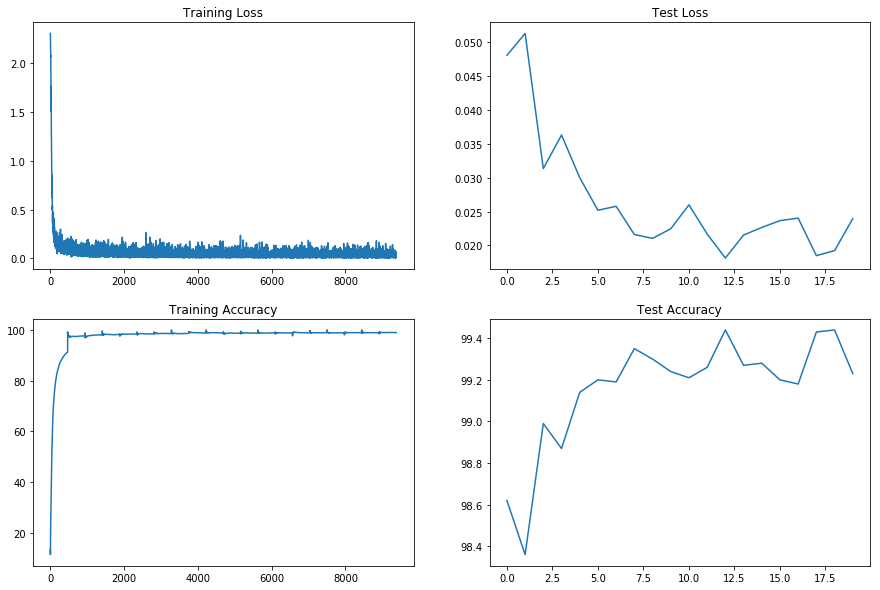

In [99]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")